<a href="https://colab.research.google.com/github/gpdsec/Residual-Neural-Network/blob/main/Custom_Resnet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*It's custom ResNet trained demonstration purpose, not for accuracy.
Dataset used is cats_vs_dogs dataset from tensorflow_dataset with **Custom Augmentatior** for data augmentation*

---


### **1. Importing Libraries**





In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, add, ReLU
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
import os
import time
%matplotlib inline


### **2. Loading & Processing Data**





##### **Loading Data**

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8WMH55/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
## Image preprocessing function
def preprocess(img, lbl):
    image = tf.image.resize_with_pad(img, target_height=224, target_width=224)
    image = tf.divide(image, 255)
    label = [0,0]
    if int(lbl) == 1:
      label[1]=1
    else:
      label[0]=1
    return image, tf.cast(label, tf.float32)

In [ ]:
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)


In [ ]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

####  **Data Augmentation layer**





In [ ]:
###### Important Variables

batch_size = 32
shape = (224, 224, 3)
training_steps = int(18610/batch_size)
validation_steps = int(2326/batch_size)
path = '/content/drive/MyDrive/Colab Notebooks/cats_v_dogs.h5'  

In [ ]:
#######  Data agumentation layer
# RandomFlip and RandomRotation Suits my need for Data Agumentation


augmentation=Sequential([
              layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
              layers.experimental.preprocessing.RandomRotation(0.2),
              ])

####### Data Shuffle and batch Function
def shufle_batch(train_set, val_set, batch_size): 
    train_set=(train_set.shuffle(1000).batch(batch_size))
    train_set = train_set.map(lambda x, y: (augmentation(x, training=True), y))
    val_set = (val_set.shuffle(1000).batch(batch_size))
    val_set = val_set.map(lambda x, y: (augmentation(x, training=True), y))
    return train_set, val_set


train_set, val_set  = shufle_batch(train_ds, val_ds, batch_size)


## **3. Creating Model**

##### **Creating Residual block**

In [ ]:
def residual_block(x, feature_map, filter=(3,3) , _strides=(1,1), _network_shortcut=False):
    shortcut = x
    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    
    if _network_shortcut :
        shortcut = Conv2D(feature_map, filter, strides=_strides, activation='relu', padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = add([shortcut, x])
    x = ReLU()(x)

    return x

In [ ]:
# Build the model using the functional API
i = Input(shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = residual_block(x, 32, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = residual_block(x,64, filter=(3,3) , _strides=(1,1), _network_shortcut=False)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='sigmoid')(x)

model = Model(i, x)

In [ ]:
model.compile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

### **4. Optimizer and loss Function** 

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [ ]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [ ]:
EPOCHS = 25
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = [] 

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  count = 0  # variable to keep tab how much data steps of training
  desc = "EPOCHS {:0>4d}".format(epoch+1)


  for images, labels in tqdm(train_set, total=training_steps, desc=desc):
    train_step(images, labels)
  
  for test_images, test_labels in val_set:
    test_step(test_images, test_labels)
 
    
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Saving BestModel

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      print(f"Saving Best Model {epoch+1}")
      model.save_weights(path)                            # Saving Model To drive
      

Epoch : 1



Loss: 0.8317787051200867, Accuracy: 60.685115814208984, Test Loss: 0.6605291366577148, Test Accuracy: 59.09286117553711
Epoch : 2



Loss: 0.5914512872695923, Accuracy: 69.32294464111328, Test Loss: 0.6914730668067932, Test Accuracy: 65.92863464355469
Epoch : 3



Loss: 0.5349869132041931, Accuracy: 74.19935607910156, Test Loss: 0.6381341218948364, Test Accuracy: 70.24935150146484
Saving Best Model 3
Epoch : 4



Loss: 0.49969255924224854, Accuracy: 76.96131134033203, Test Loss: 0.5779053568840027, Test Accuracy: 70.20635986328125
Epoch : 5



Loss: 0.46358591318130493, Accuracy: 78.6620101928711, Test Loss: 0.5075402855873108, Test Accuracy: 74.69905853271484
Saving Best Model 5
Epoch : 6



Loss: 0.4293268322944641, Accuracy: 80.93229675292969, Test Loss: 0.7444028258323669, Test Accuracy: 68.76612091064453
Epoch : 7



Loss: 0.39177319407463074, Accuracy: 83.25631713867188, Test Loss: 0.6632246971130371, Test Accuracy: 70.24935150146484
Epoch : 8



Loss: 0.36374032497406006, Accuracy: 84.61579895019531, Test Loss: 0.35200709104537964, Test Accuracy: 85.46861267089844
Saving Best Model 8
Epoch : 9



Loss: 0.34136709570884705, Accuracy: 85.56421661376953, Test Loss: 0.7350336909294128, Test Accuracy: 67.75580596923828
Epoch : 10



Loss: 0.3187144696712494, Accuracy: 86.9935531616211, Test Loss: 0.40472403168678284, Test Accuracy: 83.10404205322266
Epoch : 11



Loss: 0.2942439317703247, Accuracy: 87.99301147460938, Test Loss: 0.31237363815307617, Test Accuracy: 86.93035125732422
Saving Best Model 11
Epoch : 12



Loss: 0.27949416637420654, Accuracy: 88.29661560058594, Test Loss: 0.43894702196121216, Test Accuracy: 83.40499114990234
Epoch : 13



Loss: 0.26157650351524353, Accuracy: 89.35250091552734, Test Loss: 0.9821917414665222, Test Accuracy: 70.09888458251953
Epoch : 14



Loss: 0.24127410352230072, Accuracy: 90.23643493652344, Test Loss: 0.5637032389640808, Test Accuracy: 82.39466857910156
Epoch : 15



Loss: 0.23016147315502167, Accuracy: 90.86244201660156, Test Loss: 0.2580137252807617, Test Accuracy: 88.65003967285156
Saving Best Model 15
Epoch : 16



Loss: 0.2203349471092224, Accuracy: 91.0612564086914, Test Loss: 0.22347117960453033, Test Accuracy: 91.35855102539062
Saving Best Model 16
Epoch : 17



Loss: 0.20951242744922638, Accuracy: 91.665771484375, Test Loss: 0.2599612772464752, Test Accuracy: 88.73603057861328
Epoch : 18



Loss: 0.20119424164295197, Accuracy: 91.7248764038086, Test Loss: 0.26273399591445923, Test Accuracy: 90.28375244140625
Epoch : 19



Loss: 0.20591844618320465, Accuracy: 91.84309387207031, Test Loss: 0.19938041269779205, Test Accuracy: 91.50902557373047
Saving Best Model 19
Epoch : 20



Loss: 0.1922316998243332, Accuracy: 92.25148010253906, Test Loss: 0.20081894099712372, Test Accuracy: 91.61650848388672
Epoch : 21



Loss: 0.18188731372356415, Accuracy: 92.76464080810547, Test Loss: 0.2068275362253189, Test Accuracy: 91.38005065917969
Epoch : 22



Loss: 0.18137221038341522, Accuracy: 92.88822937011719, Test Loss: 0.3026775121688843, Test Accuracy: 84.69475555419922
Epoch : 23



Loss: 0.17430239915847778, Accuracy: 93.07093048095703, Test Loss: 0.20670464634895325, Test Accuracy: 91.40155029296875
Epoch : 24



Loss: 0.1722559779882431, Accuracy: 93.22676086425781, Test Loss: 0.17688505351543427, Test Accuracy: 92.6268310546875
Saving Best Model 24
Epoch : 25



Loss: 0.1629147082567215, Accuracy: 93.70768737792969, Test Loss: 0.23449179530143738, Test Accuracy: 90.84264373779297


### **8. Ploting Loss and Accuracy Per Iteration**

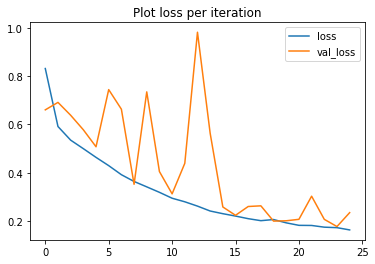

In [ ]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

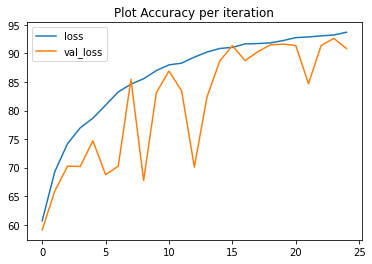

In [ ]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()

## 9. Evoluting model

##### **Note-**
Testing Accuracy of Model with Complete Unseen DataSet.

In [ ]:
model.load_weights(path)

In [ ]:
len(test_ds)

2326

In [ ]:
test_set = test_ds.shuffle(50).batch(2326)

In [ ]:
for images, labels in test_set:
  prediction = model.predict(images)
  break
## Function For Accuracy
def accuracy(prediction, labels):
    corect =0
    for i in range(len(prediction)):
      pred = prediction[i]
      labe = labels[i]
      if pred[0]>pred[1] and labe[0]>labe[1]:
        corect+=1
      elif pred[0]<pred[1] and labe[0]<labe[1]:
        corect+=1
    
    return (corect/len(prediction))*100
 

In [ ]:
print(accuracy(prediction, labels))


94.067067927773
